In [8]:
import numpy as np
from sklearn import preprocessing, neighbors, svm
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
import pandas as pd

In [9]:
df = pd.read_csv('ml_data/breast-cancer.data.txt')
df.replace('?', -99999, inplace=True)
df.drop(['id'], 1, inplace=True)

In [10]:
df.head()

,clump_thickness,unif_cell_size,unif_cell_shape,marg_adhesion,single_epithelial_cell_size,bare_nuclei,bland_chrom,normal_nucleoli,mitoses,class
0,5,1,1,1,2,1,3,1,1,2
1,5,4,4,5,7,10,3,2,1,2
2,3,1,1,1,2,2,3,1,1,2
3,6,8,8,1,3,4,3,7,1,2
4,4,1,1,3,2,1,3,1,1,2


In [11]:
X = np.array(df.drop(['class'], 1))
y = np.array(df['class'])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [13]:
clf = svm.SVC()
clf.fit(X_train, y_train)

SVC()

In [14]:
accuracy = clf.score(X_test, y_test)
print(accuracy)

0.6428571428571429


In [15]:
example_measures = np.array([[4,2,1,1,1,2,3,2,1], [4,2,1,2,2,2,3,2,1]])
example_measures = example_measures.reshape(len(example_measures), -1)

In [16]:
prediction = clf.predict(example_measures)
print(prediction)

[2 2]


In [25]:
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
style.use('ggplot')

In [33]:
class Support_Vector_Machine:
    def __init__(self, visualization=True):
        self.visualization = visualization
        self.colors = {1:'r',-1:'b'}
        if self.visualization:
            self.fig = plt.figure()
            self.ax = self.fig.add_subplot(1,1,1)
    # train
    def fit(self, data):
        self.data = data
        # { ||w||: [w,b] }
        opt_dict = {}
        transforms = [[1,1],
                      [-1,1],
                      [-1,-1],
                      [1,-1]]
        all_data = []
        for yi in self.data:
            for featureset in self.data[yi]:
                for feature in featureset:
                    all_data.append(feature)

        self.max_feature_value = max(all_data)
        self.min_feature_value = min(all_data)
        all_data = None

        # support vectors yi(xi.w+b) = 1
        
        step_sizes = [self.max_feature_value * 0.1,
                      self.max_feature_value * 0.01,
                      # point of expense:
                      self.max_feature_value * 0.001,
                      ]
        # extremely expensive
        b_range_multiple = 2
        
        # we dont need to take as small of steps with b as we do w
        b_multiple = 5
        latest_optimum = self.max_feature_value*10
        for step in step_sizes:
            w = np.array([latest_optimum,latest_optimum])
            # we can do this because convex
            optimized = False
            while not optimized:
                for b in np.arange(-1*(self.max_feature_value*b_range_multiple),
                                   self.max_feature_value*b_range_multiple,
                                   step*b_multiple):
                    for transformation in transforms:
                        w_t = w*transformation
                        found_option = True
                        # weakest link in the SVM fundamentally
                        # SMO attempts to fix this a bit
                        # yi(xi.w+b) >= 1
                        # 
                        # #### add a break here later..
                        for i in self.data:
                            for xi in self.data[i]:
                                yi=i
                                if not yi*(np.dot(w_t,xi)+b) >= 1:
                                    found_option = False
                                    #print(xi,':',yi*(np.dot(w_t,xi)+b))      
                        if found_option:
                            opt_dict[np.linalg.norm(w_t)] = [w_t,b]
                if w[0] < 0:
                    optimized = True
                    print('Optimized a step.')
                else:
                    w = w - step
            norms = sorted([n for n in opt_dict])
            #||w|| : [w,b]
            opt_choice = opt_dict[norms[0]]
            self.w = opt_choice[0]
            self.b = opt_choice[1]
            latest_optimum = opt_choice[0][0]+step*2
        for i in self.data:
            for xi in self.data[i]:
                yi=i
                print(xi,':',yi*(np.dot(self.w,xi)+self.b))            
    
    def predict(self,features):
        # sign( x.w+b )
        classification = np.sign(np.dot(np.array(features),self.w)+self.b)
        if classification !=0 and self.visualization:
            self.ax.scatter(features[0], features[1], s=200, marker='*', c=self.colors[classification])
        return classification
    
    def visualize(self):
        [[self.ax.scatter(x[0],x[1],s=100,color=self.colors[i]) for x in data_dict[i]] for i in data_dict]

        # hyperplane = x.w+b
        # v = x.w+b
        # psv = 1
        # nsv = -1
        # dec = 0
        def hyperplane(x,w,b,v):
            return (-w[0]*x-b+v) / w[1]

        datarange = (self.min_feature_value*0.9,self.max_feature_value*1.1)
        hyp_x_min = datarange[0]
        hyp_x_max = datarange[1]

        # (w.x+b) = 1
        # positive support vector hyperplane
        psv1 = hyperplane(hyp_x_min, self.w, self.b, 1)
        psv2 = hyperplane(hyp_x_max, self.w, self.b, 1)
        self.ax.plot([hyp_x_min,hyp_x_max],[psv1,psv2], 'k')

        # (w.x+b) = -1
        # negative support vector hyperplane
        nsv1 = hyperplane(hyp_x_min, self.w, self.b, -1)
        nsv2 = hyperplane(hyp_x_max, self.w, self.b, -1)
        self.ax.plot([hyp_x_min,hyp_x_max],[nsv1,nsv2], 'k')

        # (w.x+b) = 0
        # decision boundary hyperplane
        db1 = hyperplane(hyp_x_min, self.w, self.b, 0)
        db2 = hyperplane(hyp_x_max, self.w, self.b, 0)
        self.ax.plot([hyp_x_min,hyp_x_max],[db1,db2], 'y--')

        plt.show()

In [34]:
data_dict = {-1:np.array([[1,7],
                          [2,8],
                          [3,8]]),
             
             1:np.array([[5,1],
                         [6,-1],
                         [7,3]])}

Optimized a step.
Optimized a step.
Optimized a step.
[1 7] : 1.271999999999435
[2 8] : 1.271999999999435
[3 8] : 1.0399999999995864
[5 1] : 1.0479999999990506
[ 6 -1] : 1.7439999999985962
[7 3] : 1.0479999999990506


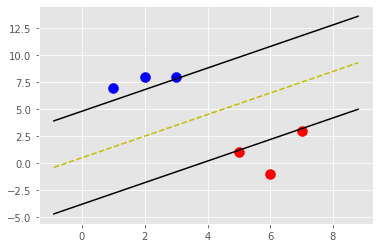

In [35]:
svm = Support_Vector_Machine()
svm.fit(data=data_dict)
svm.visualize()

Optimized a step.
Optimized a step.
Optimized a step.
[1 7] : 1.271999999999435
[2 8] : 1.271999999999435
[3 8] : 1.0399999999995864
[5 1] : 1.0479999999990506
[ 6 -1] : 1.7439999999985962
[7 3] : 1.0479999999990506


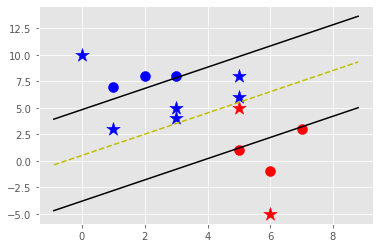

In [36]:
svm = Support_Vector_Machine()
svm.fit(data=data_dict)

predict_us = [[0,10],
              [1,3],
              [3,4],
              [3,5],
              [5,5],
              [5,6],
              [6,-5],
              [5,8]]

for p in predict_us:
    svm.predict(p)
svm.visualize()